100%|██████████| 170498071/170498071 [00:14<00:00, 12141491.58it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can als

Epoch 1/10, Loss: 0.10459538914126376, Accuracy: 0.957
Epoch 2/10, Loss: 0.026402817319181506, Accuracy: 0.9909
Epoch 3/10, Loss: 0.011108374121923784, Accuracy: 0.9966
Epoch 4/10, Loss: 0.008345953654823305, Accuracy: 0.9973
Epoch 5/10, Loss: 0.006645280771949045, Accuracy: 0.9985
Epoch 6/10, Loss: 0.005589387936197454, Accuracy: 0.9985
Epoch 7/10, Loss: 0.0031520774584013807, Accuracy: 0.9991
Epoch 8/10, Loss: 0.002893386969754791, Accuracy: 0.9992
Epoch 9/10, Loss: 0.0025373520244805297, Accuracy: 0.9993
Epoch 10/10, Loss: 0.0020248891893096094, Accuracy: 0.9995


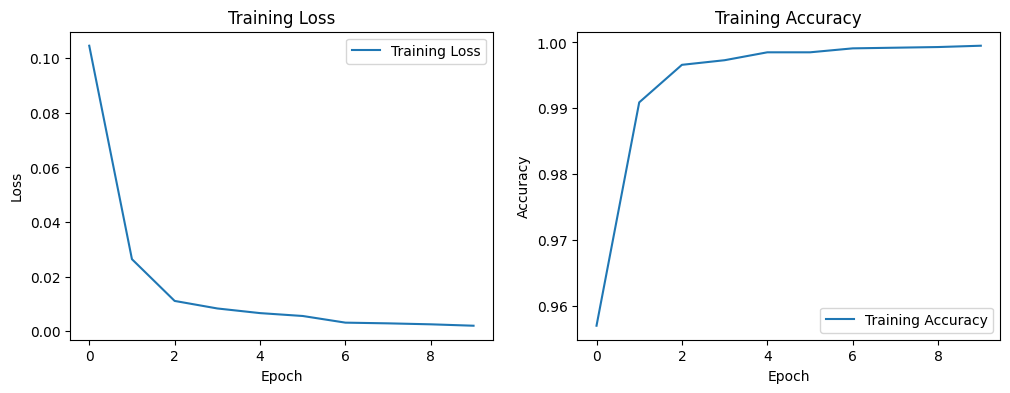

Accuracy on the test set: 99.35%


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision import models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Load Cifar-10 dataset
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# Filter the dataset for Automobile (class 1) and Airplane (class 0)
classes_of_interest = [0, 1]  # Airplane, Automobile
train_indices = [i for i, label in enumerate(train_dataset.targets) if label in classes_of_interest]
train_dataset = torch.utils.data.Subset(train_dataset, train_indices)

# Similarly, filter the test dataset
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_indices = [i for i, label in enumerate(test_dataset.targets) if label in classes_of_interest]
test_dataset = torch.utils.data.Subset(test_dataset, test_indices)

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

# Load pre-trained ResNet model
resnet = models.resnet18(pretrained=True)

# Keep the weights of the existing layers and only replace the fully connected layer
num_classes = len(classes_of_interest)
resnet.fc = nn.Linear(resnet.fc.in_features, num_classes)

# Initialize the fully connected layer with random weights
nn.init.xavier_uniform_(resnet.fc.weight)
nn.init.zeros_(resnet.fc.bias)

# Move the model to the device
resnet.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet.parameters(), lr=0.001, momentum=0.9)

# Training loop
num_epochs = 10
losses = []
accuracies = []

for epoch in range(num_epochs):
    resnet.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = resnet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = correct / total

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss}, Accuracy: {epoch_accuracy}")

    losses.append(epoch_loss)
    accuracies.append(epoch_accuracy)

# Plotting
plt.figure(figsize=(12, 4))

# Plotting Loss
plt.subplot(1, 2, 1)
plt.plot(losses, label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plotting Accuracy
plt.subplot(1, 2, 2)
plt.plot(accuracies, label='Training Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# Evaluation
resnet.eval()
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = resnet(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f"Accuracy on the test set: {100 * accuracy:.2f}%")
